In [1]:
import czifile
import os
import pathlib
import numpy as np
import skimage as ski

# Aim
Create slide overviews from slide scan of the Axioscan Z1 from the ZMB. These overviews could be used in the hyperion

# Backround
The slidescanner produces .czi files, one for he label, one for the slide and one with the scan. These need to be combined to one slide overview

# Approach

Write a python script to combine label and slide overview into 1 png.

# Status
This works but the slide scans are slightly miss-aligned
=> Improvements:
- detect slide vs background or the slide-alignment crosses and use these to correclty transform the slides, such that they fit better

In [2]:
class Config:
    " Keeps all configuration variables "
    # a folder containing all the slide scan images, e.g. as provided by the ZMB after scanning
    fol_input = pathlib.Path('/mnt/data/vitoz/RawData/slidescanner_uncompressed/slidescanner_transfer_20190510_0015/')
    # the output folder
    fol_out = pathlib.Path('/home/vitoz/Data/20190512_imcoverviews')
C = Config

In [3]:
class Vars:
    " Keeps all global variables "
    SUFFIX_CZI = '.czi'
    SUFFIX_LABEL = '_pt1'
    SUFFIX_SLIDEOV = '_pt2'
V = Vars

In [4]:
# create the output folder
C.fol_out.mkdir(exist_ok=True)

### Define the slidescan class
(could be moved into a helper library)

In [5]:
class SlideScan:
    fileformat = V.SUFFIX_CZI
    def __init__(self, basename):
        """
        Get a slidescan based on it's main slidescan file.
        The label and slideoverview are infered from this.
        """
        self.basename = basename
        
    def get_labelimg(self):
        """
        get the label image
        """
        return self._read_img(self.fn_label)
    
    def get_slideovimg(self):
        """
        get the overview image
        """
        return self._read_img(self.fn_slideov)
    
    @property
    def fn_slide(self):
        return self.basename
    
    @property
    def fn_slideov(self):
        fn = self.basename
        return fn.parent / (fn.stem + V.SUFFIX_SLIDEOV +fn.suffix)
    
    @property
    def fn_label(self):
        fn = self.basename
        return fn.parent / (fn.stem + V.SUFFIX_LABEL +fn.suffix)
    
    def get_full_overview(self, aspect=3):
        """
        Stitches the label and slideoverview to a full slide overview image.
        
        +-------+--------------+
        | label | slidoverview | 
        |       |              | height
        +-------+--------------+
                  width
        Params:
            aspect: the slide aspect ratio width/height:
                    3 in a standard histology slide
        Returns:
            RGB array of the stitched image
        """
        ndim = 3
        slideov = self._norm_img(self.get_slideovimg().squeeze())
        label = self._norm_img(self.get_labelimg().squeeze())
        
        # find the height:
        slide_h = max(slideov.shape[0], label.shape[0])
        # calculate the width
        slide_w = slide_h*aspect
        
        # rescale the images to make them the same height
        def rescale(img, h):
            scale = h/img.shape[0]
            if scale == 1:
                return img
            else:
                return ski.transform.rescale(img,scale, multichannel=True)
            
        slideov, label = (rescale(img, slide_h) for img in (slideov, label))
        # initialize output array:
        ov_img = np.zeros((slide_h, slide_w, ndim), dtype=np.float)
        
        # fill the left part of the image with the slide image
        w, h, d = slideov.shape
        ov_img[-w:, -h:, :] = slideov
        
        # fill the right part with the label
        w, h, d = label.shape
        ov_img[:w, :h, :] = label
        return ov_img
    
    @staticmethod
    def _read_img(path):
        " Read the image"
        img = czifile.imread(path)
        return img
    
    @staticmethod
    def _norm_img(img):
        return ski.exposure.equalize_adapthist(img)
        

# Get all the slidescans and save their overviews

In [6]:
fn_scans = [f for f in C.fol_input.glob('*.czi') if not(f.stem.endswith(V.SUFFIX_LABEL) | f.stem.endswith(V.SUFFIX_SLIDEOV))]

In [7]:
for fn in fn_scans:
    scan = SlideScan(fn)
    img = scan.get_full_overview() # generates the slide overview
    ski.io.imsave(
        C.fol_out / (scan.basename.stem +'.png'), # save in the output folder with the original slidescan name
        ski.img_as_ubyte(ski.transform.rotate(img, 180)), # rotate 180 degrees such that the image is suitable for the hyperion & convert to uint8
    )

/home/vitoz/miniconda2/envs/testenv/envs/cziconvert/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/vitoz/miniconda2/envs/testenv/envs/cziconvert/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


### Visualization of an example overview:

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
scan = SlideScan(fn_scans[0])
img = scan.get_full_overview()
img = ski.img_as_ubyte(ski.transform.rotate(img, 180))

/home/vitoz/miniconda2/envs/testenv/envs/cziconvert/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/vitoz/miniconda2/envs/testenv/envs/cziconvert/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


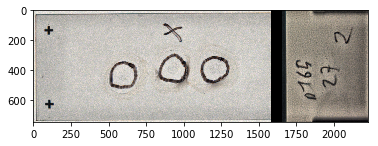

In [10]:
plt.figure()
plt.imshow(img)

## Environment

In [11]:
import sys
!conda env export -p {sys.prefix} 

name:
channels:
  - r
  - conda-forge
  - bioconda
  - defaults
dependencies:
  - anaconda=custom=py37_0
  - attrs=19.1.0=py_0
  - backcall=0.1.0=py_0
  - bleach=3.1.0=py_0
  - bzip2=1.0.6=h14c3975_1002
  - ca-certificates=2019.3.9=hecc5488_0
  - certifi=2019.3.9=py37_0
  - cloudpickle=1.0.0=py_0
  - cycler=0.10.0=py_1
  - cytoolz=0.9.0.1=py37h14c3975_1001
  - dask-core=1.2.2=py_0
  - dbus=1.13.6=he372182_0
  - decorator=4.4.0=py_0
  - defusedxml=0.5.0=py_1
  - entrypoints=0.3=py37_1000
  - expat=2.2.5=hf484d3e_1002
  - fontconfig=2.13.1=he4413a7_1000
  - freetype=2.10.0=he983fc9_0
  - gettext=0.19.8.1=hc5be6a0_1002
  - glib=2.58.3=hf63aee3_1001
  - gst-plugins-base=1.14.4=hdf3bae2_1001
  - gstreamer=1.14.4=h66beb1c_1001
  - icu=58.2=hf484d3e_1000
  - imageio=2.5.0=py37_0
  - ipykernel=5.1.0=py37h24bf2e0_1002
  - ipympl=0.2.1=py37_1001
  - ipython=7.5.0=py37h24bf2e0_0
  - ipython_genutils=0.2.0=py_1
  - ipywidgets=7.4.2=py_0
  - jedi=0.13.3=py37_0
  - jinja2=2.10.1=py_0
  - jpeg=9c=h14